<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/5_Modelos_de_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

## Estimación de un Modelo de Elección de "Ubicación Residencial" adaptado a una situación de vivir en la formalidad vs. la informalidad.

A modo de ejemplo, vamos a intentar explicar predecir la localización de los hogares en las áreas de la "ciudad formal" o en los "asentamientos informales". Vamos a utilizar un extracto de los datos de la investigación de Goytia, Heikkila, Pasquini (2020).
   

## Descripción de variables
* bformal es una dummy que señala con 1 a las areas "formales" y 0 a las areas "informales". Este es un criterio de delimitación espacial.  "Informal" se utiliza para el área que constituye un barrio popular  
* dconurb1, dconurb2, dconurb3 son dummies que señalan a los agrupamientos de partidos del AMBA "Conurbano 1", "Conurbano 2" y "Conurbano 3" respectivamente, según la categorización del INDEC.  Vease https://www.indec.gob.ar/dbindec/folleto_gba.pdf
* dprop_soloviv', 'dprop_ocupant', 'dinquilinos' son dummies que señalan a los que son propietarios solo de la vivienda, ocupantes e inquilinos respectivamente.
* dedu_secincomp', 'dedu_seccomp', 'dedu_ter_o_mas' son dummies que señalan la educación del jefe de hogar
* 'dconexionagua1', 'delectricidad_med', 'dconexiongas'  son dummies que señalan la presencia de conexión al agua de red, la presencia de un medidor de electricidad y la conexión al gas de red respectivamente.

El modelo que propondremos consistirá en explicar la condición de vivir en el "área formal" a partir de un conjunto de atributos del hogar, incluyendo el ingreso, el tamaño, y un conjunto de variabes indicadores del nivel educativo del jefe de hogar.

Proponemos un Modelo Logit. Recordemos que este modelo puede pensar como el modelo de regresión lineal que es transformado mediante la función logística:

$$P(F=1)_i=\frac{1}{1+e^{-Z_i}} $$

donde

$$Z_i=\beta_0+\beta_1IngresoHogar_i+\beta_1TamañoHogar_i+\beta_2DSecundarioCompleto_i+\beta_2DTerciarioCompleto_i+\epsilon_i$$


**Observación:** Una propiedad de este modelo que puede ser útil más adelante es notar que este modelo cumple que el *ratio de las chances* de vivir en el sector formal (definido en este caso como la probabilidad de F=1 sobre la probabilidad de F=0) tomado en logaritmo se asume de forma lineal:


$$\log(\frac{P(F=1)}{P(F=0)})=\beta_0+\beta_1IngresoHogar_i+\beta_1TamañoHogar_i+\beta_2DSecundarioCompleto_i+\beta_2DTerciarioCompleto_i+\epsilon_i$$

Esta última expresión es útil pues, al aparecer P(F=0) explicita que la probabilidad de pertenecer a una categoria se define siempre en relación a otra categoría. Esto será útil para la interpretación del modelo multi-categoría.

In [2]:
# Levantamos los datos
datosghp=pd.read_csv('https://raw.githubusercontent.com/rpasquini/urban-econometrics/master/data/formal%20premia%20data%20extract.csv')

In [3]:
# Cada observación es un hogar
datosghp

,hora_c,hora_f,bformal,dconurb1,dconurb2,dconurb3,dmore2000,dprop_soloviv,dprop_ocupant,dinquilinos,...,m2,dconexionagua1,dconexionagua2,dconexionagua3,dpagaelagua,dcloaca,delectricidad_med,dconexiongas,alquiler2,ingresohogar2
0,14.30,14.55,0,0,0,0,1,1,0,0,...,2,0,0,1,0.0,1,1,0,12000.0,16500.0
1,13.30,13.55,0,0,0,0,1,0,0,1,...,2,0,0,1,0.0,1,1,0,2000.0,12000.0
2,14.25,14.50,0,0,0,0,1,1,0,0,...,2,0,0,1,0.0,0,0,0,3000.0,15000.0
3,11.05,11.30,0,0,0,0,1,1,0,0,...,2,0,0,1,NaN,0,0,0,6000.0,8000.0
4,9.35,10.00,0,0,0,0,1,1,0,0,...,1,0,0,1,0.0,0,0,0,NaN,6800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,10.10,10.50,1,0,0,1,0,0,0,0,...,1,0,1,0,0.0,0,1,0,7000.0,25000.0
546,11.40,12.10,1,0,0,1,0,0,0,1,...,1,0,1,0,0.0,0,1,1,5000.0,10000.0
547,12.10,12.35,1,0,0,1,0,0,0,0,...,2,0,1,0,0.0,0,1,1,5000.0,10000.0
548,11.00,11.30,1,0,0,1,0,0,0,0,...,2,0,1,0,0.0,0,1,1,NaN,14000.0


In [4]:
def logit(lista, data):
  """
  Funcion que realiza la regresion Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Logit(Y,X) # Aqui llamamos al método Logit de StatsModels
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [5]:
modeloajustado=logit(['bformal', 'ingresohogar2', 'npersonashogar','dedu_seccomp',	'dedu_ter_o_mas'], datosghp)

Optimization terminated successfully.
         Current function value: 0.665327
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                bformal   No. Observations:                  501
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            4
Date:                Fri, 14 Jul 2023   Pseudo R-squ.:                 0.03451
Time:                        00:44:25   Log-Likelihood:                -333.33
converged:                       True   LL-Null:                       -345.24
Covariance Type:            nonrobust   LLR p-value:                 8.645e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8477      0.267     -3.176      0.001      -1.371      -0.324
ingresohogar2   3

¿Cuál es la probabilidad de que una familia de que una familia con cuatro integrantes, ingreso del hogar de $14000, y jefe con secundario incompleto viva en la formalidad? \
A mano:


In [ ]:
import numpy as np

z0=-0.8477+0.00003727*14000-0.0141*4+0*0.6655+0*0.67
f0=1/(1+np.exp(-z0))
f0

0.4055674633633202

Usando el metodo predict


In [ ]:
modeloajustado.predict([1,14000,4,0,0])


array([0.4056167])

##  Computando los efectos marginales:


In [ ]:
# average of the marginal effects in the data (default)
probit_margeff = modeloajustado.get_margeff()
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.809e-06   3.16e-06      2.792      0.005    2.62e-06     1.5e-05
npersonashogar    -0.0033      0.011     -0.299      0.765      -0.025       0.018
dedu_seccomp       0.1573      0.048      3.289      0.001       0.064       0.251
dedu_ter_o_mas     0.1599      0.087      1.846      0.065      -0.010       0.330


In [ ]:
# average of the marginal effects in the data (default)
probit_margeff = modeloajustado.get_margeff(at='mean')
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                              mean
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   9.241e-06   3.41e-06      2.712      0.007    2.56e-06    1.59e-05
npersonashogar    -0.0035      0.012     -0.299      0.765      -0.026       0.019
dedu_seccomp       0.1650      0.052      3.158      0.002       0.063       0.267
dedu_ter_o_mas     0.1677      0.092      1.822      0.068      -0.013       0.348


In [ ]:
probit_margeff = modeloajustado.get_margeff(atexog={1:14000, 2:4, 3:0, 4:0})
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.987e-06   3.35e-06      2.680      0.007    2.41e-06    1.56e-05
npersonashogar    -0.0034      0.011     -0.299      0.765      -0.026       0.019
dedu_seccomp       0.1604      0.049      3.275      0.001       0.064       0.256
dedu_ter_o_mas     0.1631      0.088      1.846      0.065      -0.010       0.336


# Versión Probit
El modelo Probit representa una alternativa al modelo Logit. La función que realiza la transformación en este caso es la [función acumulativa](https://en.wikipedia.org/wiki/Cumulative_distribution_function) de la [Distribución Normal Estandar](https://en.wikipedia.org/wiki/Normal_distribution), que es típicamente denotada $\Phi$. Es decir:

$$P(F=1)=\Phi(\beta_0+\beta_1IngresoHogar_i+\beta_1TamañoHogar_i+\beta_2DSecundarioCompleto_i+\beta_2DTerciarioCompleto_i+\epsilon_i)$$

In [ ]:
def probit(lista, data):
  """
  Funcion que realiza la regresion probit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Probit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [ ]:
modeloajustado=probit(['bformal', 'ingresohogar2', 'npersonashogar','dedu_seccomp',	'dedu_ter_o_mas'], datosghp)

Optimization terminated successfully.
         Current function value: 0.665310
         Iterations 4
                          Probit Regression Results                           
Dep. Variable:                bformal   No. Observations:                  501
Model:                         Probit   Df Residuals:                      496
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                 0.03453
Time:                        18:28:14   Log-Likelihood:                -333.32
converged:                       True   LL-Null:                       -345.24
Covariance Type:            nonrobust   LLR p-value:                 8.578e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5269      0.164     -3.208      0.001      -0.849      -0.205
ingresohogar2   2

In [ ]:
probit_margeff = modeloajustado.get_margeff()
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.799e-06   3.12e-06      2.817      0.005    2.68e-06    1.49e-05
npersonashogar    -0.0033      0.011     -0.295      0.768      -0.025       0.018
dedu_seccomp       0.1584      0.048      3.269      0.001       0.063       0.253
dedu_ter_o_mas     0.1626      0.087      1.869      0.062      -0.008       0.333


# Estimando un Modelo de Localización Residencial en la Ciudad. Aplicación del modelo de múltiples categorías.



In [2]:
comunas=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/econometrics_and_causality/blob/master/comunas.zip?raw=true")

In [3]:
comunas

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10..."
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10..."
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10..."
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998..."
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583..."
5,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,10.0,6,LIMITE COMUNAL,"POLYGON ((97703.854 101010.270, 97716.104 1009..."
6,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,11.0,7,LIMITE COMUNAL,"POLYGON ((96781.486 103649.395, 96892.479 1035..."
7,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,12.0,8,LIMITE COMUNAL,"POLYGON ((96329.447 103927.833, 96314.729 1039..."
8,PALERMO,22126.531858,1.584587e+07,14.0,9,LIMITE COMUNAL,"POLYGON ((103353.744 108568.622, 103353.843 10..."
9,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,3.0,10,LIMITE COMUNAL,"POLYGON ((104713.283 103467.380, 104862.315 10..."


<Axes: >

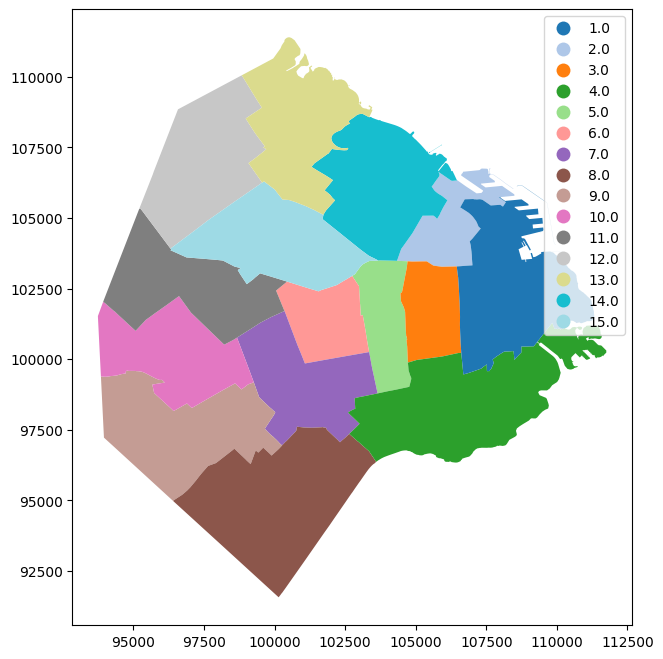

In [17]:
comunas.plot('COMUNAS', legend=True, categorical=True, figsize=(8, 8), cmap='tab20')


Estimaremos un modelo de localicalización usando la Encuesta Anual de Hogares de la Dirección General de Estadística y Censos de la Ciudad de Buenos Aires (EAH
Véase https://www.estadisticaciudad.gob.ar/eyc/?cat=93)

Lo que buscamos es poder explicar/predecir la elección de la comuna donde un hogar vivirá a partir de un conjunto de características explicativas. En este ejemplo,  para simplificar, vamos a trabajar con la encuesta a las personas, y estimaremos el modelo utilizando los datos del jefe del hogar.

In [28]:
dataeah=pd.read_csv("https://github.com/rpasquini/econometrics_and_causality/blob/master/eah2016.csv?raw=true")


In [29]:
dataeah.columns

Index(['id', 'nhogar', 'miembro', 'comuna', 'dominio', 'edad', 'sexo',
       'parentes_2', 'p5_2', 'p6_a', 'p6_b', 'estado', 'categori', 't13',
       't14', 't18', 't28', 't29', 't29a', 't30', 'sem_hs', 't33', 't34',
       't35', 't37_cod_2', 't37_coda_2', 't38', 't39', 't40', 't41_cod_2',
       't47', 't48', 't51_bis', 'i1', 'i4', 'i6_3', 'i10', 'i11', 'codioph',
       'ioph_2', 'codioph_neto', 'ioph_neto_2', 'codios', 'ios_2', 'codioa',
       'ioa_2', 'codlab', 'inglab_2', 'codi3_1x', 'i3_1x_2', 'codi3_2x',
       'i3_2x_2', 'codi3_8x', 'i3_8x_2', 'codi3_est', 'i3_est_2', 'codi3_otr',
       'i3_otr_2', 'codnolab', 'ingnolab_2', 'coding', 'ingtot_2', 'codi_tot',
       'itfb_2', 'ipcfb_2', 'e2', 'e4', 'e6', 'e8', 'e12', 'e13', 'e14',
       'edad_30', 'nivel', 'aesc', 'm1', 'm1_2', 'm2_anio', 'm3_anio',
       'tipcob2_2', 'sn1_1', 'sn1_7', 'sn1_2', 'sn1_3', 'sn1_4', 'sn1_5', 's8',
       'sn14', 'sn16', 's28', 's29', 'fexp', 'sexotexto'],
      dtype='object')

In [30]:
# Para el ejemplo nos quedaremos con las caracteristicas del jefe de hogar, codificado como 1 en la variable parentes_2
dataeah=dataeah[dataeah['parentes_2']==1]

Como variables explicativas tomaremos la edad y el monto del ingreso total individual (variable ingtot_2)

<Axes: >

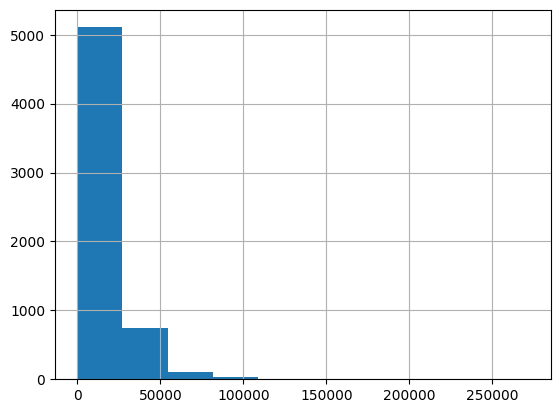

In [32]:
dataeah["ingtot_2"].hist()

El modelo a estar sera un Multinomial Logit. Este modelo se puede pensar como una generalización del modelo Logit para una cantidad de K categorías. Podemos pensar a este modelo como la modelización de K-1 ecuaciones tomando como base a una categoría de referencia (la K-esima).  

Al igual que el Logit, este modelo tiene la propiedad de que el logaritmo del ratio de las chances entre las categorías se modela de manera lineal. En este caso, el logaritmo del ratio de las chances de una categroria k-esima en relación a la categoría K (la última), se puede escribir como:

$$ \ln(\frac{\Pr(Y=k)}{\Pr(Y=K)})=\beta_{0,k}+\beta_{1,k}X_i+\epsilon_i$$

El modelo tiene similares implicancias al Logit de dos categorías: Los efectos del modelo en las probabilidades serán no-lineales (i.e., dependerán de los valores de las variables explicativas) y será necesario estimar los *efectos marginales*.



In [33]:
def mnlogit(lista, data):
  """
  Funcion que realiza la regresion Multinomial Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.MNLogit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [34]:
modeloajustado=mnlogit(['comuna', 'ingtot_2', 'edad'], dataeah)

Optimization terminated successfully.
         Current function value: 2.623895
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                 comuna   No. Observations:                 6000
Model:                        MNLogit   Df Residuals:                     5958
Method:                           MLE   Df Model:                           28
Date:                Mon, 17 Jul 2023   Pseudo R-squ.:                 0.01531
Time:                        21:22:51   Log-Likelihood:                -15743.
converged:                       True   LL-Null:                       -15988.
Covariance Type:            nonrobust   LLR p-value:                 9.079e-86
  comuna=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8967      0.198     -4.529      0.000      -1.285      -0.509
ingtot_2    3.483e-05   4.51e

In [35]:
probit_margeff = modeloajustado.get_margeff(atexog={1:50000, 2:30})
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
       MNLogit Marginal Effects      
Dep. Variable:                 comuna
Method:                          dydx
At:                           overall
  comuna=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ingtot_2   -1.723e-06   1.28e-07    -13.476      0.000   -1.97e-06   -1.47e-06
edad          -0.0006      0.000     -2.842      0.004      -0.001      -0.000
------------------------------------------------------------------------------
  comuna=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ingtot_2    2.149e-06    5.1e-07      4.217      0.000    1.15e-06    3.15e-06
edad          -0.0016      0.000     -3.200      0.001      -0.003      -0.001
------------------------------------------------------------------------------
  comuna=3      dy/dx    std err       

In [ ]:
modeloajustado.predict([1,20000,60])

array([[0.09499062, 0.07188986, 0.08289212, 0.07545277, 0.06886398,
        0.07374537, 0.07111894, 0.06279312, 0.04695586, 0.04613311,
        0.03362737, 0.0639365 , 0.07455247, 0.07169329, 0.06135463]])